## Problem 5: U Auto-encoder on Fashion MNIST

In [1]:
# Step 1: Download the Fashion MNIST data using PyTorch

import torch
from torchvision import datasets, transforms
import torch.nn as nn
import numpy as np

# Define the transformations to be applied to the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download the Fashion MNIST training dataset
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Create a dataloader to load the data in batches
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 15987116.55it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 273917.03it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5078377.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 8032841.14it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [2]:
# Step 2: Use an auto-encoder to reduce the dimension to two
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Tanh()
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(decoded.size(0), 1, 28, 28)
        return encoded, decoded


In [3]:

# Device to be used (GPU if available, else CPU), 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define the autoencoder and move it to the device
autoencoder = Autoencoder().to(device)

# Define the loss function (MSE loss) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)

        # Forward pass
        encoded, decoded = autoencoder(img)
        loss = criterion(decoded, img)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

# Get the encoded features for the training data
encoded_train = []
with torch.no_grad():
    for data in train_loader:
        img, label = data
        img = img.to(device)
        encoded, decoded = autoencoder(img)
        encoded_train.append(encoded.cpu().numpy()) 
encoded_train = np.concatenate(encoded_train) # concatenate all the encoded features into a single array

Using device: cuda
Epoch [1/20], Loss: 0.1238
Epoch [2/20], Loss: 0.1061
Epoch [3/20], Loss: 0.1094
Epoch [4/20], Loss: 0.1154
Epoch [5/20], Loss: 0.1119
Epoch [6/20], Loss: 0.1194
Epoch [7/20], Loss: 0.0930
Epoch [8/20], Loss: 0.1106
Epoch [9/20], Loss: 0.1174
Epoch [10/20], Loss: 0.0977
Epoch [11/20], Loss: 0.0979
Epoch [12/20], Loss: 0.0993
Epoch [13/20], Loss: 0.1013
Epoch [14/20], Loss: 0.1006
Epoch [15/20], Loss: 0.0880
Epoch [16/20], Loss: 0.1012
Epoch [17/20], Loss: 0.0993
Epoch [18/20], Loss: 0.0980
Epoch [19/20], Loss: 0.1111
Epoch [20/20], Loss: 0.0940


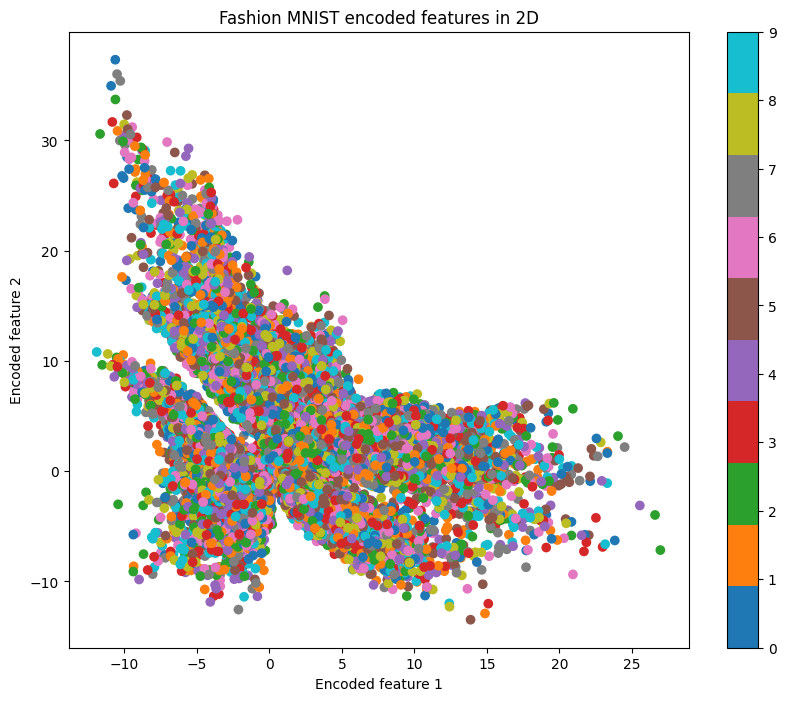

In [4]:
# Step 3: Plot the points in the reduced feature space with color-coded class labels
import matplotlib.pyplot as plt
import numpy as np

# Get the class labels for the training data
labels_train = train_data.targets.numpy()

# Plot the encoded features in 2D with color-coded class labels
plt.figure(figsize=(10, 8))
plt.scatter(encoded_train[:, 0], encoded_train[:, 1], c=labels_train, cmap='tab10')
plt.colorbar()
plt.title('Fashion MNIST encoded features in 2D')
plt.xlabel('Encoded feature 1')
plt.ylabel('Encoded feature 2')
plt.show()

# The x-axis represents the first encoded feature, the y-axis represents the second encoded feature, 
# The color-coded class labels